In [1]:
import xgboost as xgb
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import LeavePGroupsOut, cross_val_score, GroupShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from statistics import mean
import scipy

from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from math import sqrt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("training_data.csv")
df =df.fillna(df.median())
df2 = pd.read_csv("old_training_data.txt")
df2 =df2.fillna(df.median())

common_cols = [col for col in set(df.columns).intersection(df2.columns)] #just in case remove any features not shared by the two data sets
df = df[common_cols]
df2 = df2[common_cols]

In [3]:
y = df["Target"]
X = df.drop(["Target"], axis=1) 

y_old = df2["Target"]
X_old = df2.drop(["Target"], axis=1)

X_train = X.drop(["StudentID"], axis=1)
X_old_train=X_old.drop(["StudentID"], axis=1) 



features = list(df.columns)
features.remove("Target")
features.remove("StudentID")
train_label = "Target"

In [4]:
def standard_error(roc_auc, num_pos, num_neg):
    roc_auc_squared = roc_auc**2
    d_pos = (num_pos-1)*(roc_auc/(2-roc_auc)-roc_auc_squared)
    d_neg = (num_neg-1)*((2*roc_auc_squared)/(1+roc_auc)-roc_auc_squared)
    return sqrt((roc_auc*(1-roc_auc) + d_pos + d_neg)/(num_pos*num_neg)) 

def z_score(roc_auc1, roc_auc2, se1, se2):
    return((roc_auc1 - roc_auc2)/(sqrt(se1**2 + se2**2)))

def TrainModels(df, groupID, nSplits, text, clf, name, sm=True):
            toRet = {}
            models = []
            groups = df[groupID]
            finalPreds = pd.DataFrame(index=df.index, columns=['probability_predict', 'label_predict','label'], dtype=float)
            for iter_num, fold_indices in enumerate(GroupKFold(n_splits=4).split(X=df, groups=groups)):
                train_indices = fold_indices[0]
                test_indices = fold_indices[1]

                train_inst = df.iloc[train_indices].copy()
                test_inst = df.iloc[test_indices].copy()

                train_X = train_inst[features].copy()
                train_y = train_inst[train_label].copy()

                test_x = test_inst[features].copy()
                test_y = test_inst[train_label].copy()
                
                if(sm):
                    sm = SMOTE(random_state=42)
                    train_X, train_y = sm.fit_resample(train_X,train_y)

                clf.fit(train_X, train_y)
                models.append(clone(clf))
                probs = clf.predict_proba(test_x)
                label_predict = clf.predict(test_x)
                df_prob = pd.DataFrame(probs, columns=["P0", "P1"], index=test_y.index)
    #             print(probs)
    #             print(df_prob)
#                 test_y = test_y.to_frame()
#                 test_y["Prob"] = df_prob["P1"].copy()
    #             print(test_y)
                finalPreds['probability_predict'].iloc[test_indices] = probs[:,1] 
                finalPreds['label_predict'].iloc[test_indices] = label_predict
                finalPreds['label'].iloc[test_indices] = test_y
#                 print(finalPreds)
            csv_name = str(name) + "_finalPredictions_with_proba.csv"
            finalPreds.to_csv(csv_name)
            print

            roc = roc_auc_score(finalPreds['label'], finalPreds["probability_predict"])

            new_se = standard_error(roc, df[train_label].value_counts()[1],df[train_label].value_counts()[0])
            #print("{0}: {1} roc_auc: {2}".format(text,name,roc))
            #print ("StandardError = {0}".format(new_se))
            return [roc, new_se, models]
            return 
def remove_outliers(df, id_column):
    for col in df.columns:
        if(col!=id_column and col!='Target'):
            y = df[col]
            outliers = y.between(y.quantile(0.01), y.quantile(0.99))
            index_to_remove = df[~outliers].index
            df.drop(index_to_remove, inplace=True)
    return df

In [217]:
#df = remove_outliers(df, 'StudentID')
#df2 = remove_outliers(df2, 'StudentID')

In [218]:
#Spot Check Means
#df.describe()
#df2.describe()
#for c in df.columns.to_list():
   # if(c != 'StudentID'): print("{2} -- MeanNEW: {0} , MeanOLD {1}".format(df[c].mean(), df2[c].mean(), c))

In [6]:
i=0
names = [
    "Dummy",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "XGBoost"
]
averages = {}
for name in names:
    averages[name] = ([],[],[])
while i<1000:
    classifiers = [
        DummyClassifier(strategy="stratified"),
        DecisionTreeClassifier(max_depth = 5, random_state = i),
        RandomForestClassifier(max_depth = 5, random_state = i),
        MLPClassifier(random_state = i),
        xgb.XGBClassifier(random_state = i, use_label_encoder=False, eval_metric='logloss')
    ]

    res_NEW = {}
#     res_OLD = {}
    finalPreds = pd.DataFrame(index=df.index, columns=['probability_predict', 'label_predict','label'], dtype=float)

    print(i)

    for name, clf in zip(names, classifiers):
        res_NEW[name] = TrainModels(df, "StudentID", 4, "NEW", clf, name)
#         res_OLD[name] = TrainModels(df2, "StudentID", 4, "OLD", clf, name)
        
        sm = SMOTE(random_state=42)
        oldX_train, oldY_train = sm.fit_resample(df2[features], df2[train_label])  
        clf.fit(oldX_train, oldY_train)
        probs = clf.predict_proba(df[features])
        label_predict = clf.predict(df[features])                                  
        roc_auc_old_to_new = metrics.roc_auc_score(df[train_label],clf.predict_proba(df[features])[:, 1]) #score on the full new data
        finalPreds['probability_predict'] = probs[:,1] 
        finalPreds['label_predict'] = label_predict
        finalPreds['label'] = df[train_label]
#                 print(finalPreds)
        csv_name = str(name) + "_finalPredictions_old_to_new_with_proba.csv"
        finalPreds.to_csv(csv_name)
        #print("OldToNew: " + name + " roc_auc: "+ str(roc_auc_old_to_new))
#         old_to_new_se = standard_error(roc_auc_old_to_new, y.value_counts()[1],y.value_counts()[0])
        #print ("StandardError = ", old_to_new_se)
        #print("Z-Score OTN versus N: ", z_score(res_NEW[name][0], roc_auc_old_to_new, res_NEW[name][1], old_to_new_se))
        #print("Z-Score OTN versus O: ", z_score(roc_auc_old_to_new, res_OLD[name][0], old_to_new_se, res_OLD[name][1]), "\n")
#         averages[name][0].append(res_NEW[name][0])
#         averages[name][1].append(res_OLD[name][0])
#         averages[name][2].append(roc_auc_old_to_new)
        
    i+=10


0
10


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


20


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


30
40


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


50


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


60


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


70


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


80


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


90
100


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


110
120
130
140
150
160


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


170
180


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


190
200


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


210


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


220


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


230


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


240
250


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


260


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


270


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


280
290
300
310


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


320


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


330


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


340


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


350


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


360


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


370
380
390


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


400


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


410
420


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


430


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


440


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


450


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


460


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


470
480


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


490


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


500


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


510


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


520
530
540
550


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


560


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


570
580
590


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


600


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


610


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


620


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


630


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


640
650


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


660
670
680
690


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


700


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


710


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


720


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


730


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


740
750
760
770


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


780
790
800


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


810
820
830


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


840


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


850


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


860
870


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_netw

880
890
900
910


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


920


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


930


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


940


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


950


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


960
970
980


/Users/clarabelitz/.pyenv/versions/3.6.8/envs/detector_rot/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


990


In [7]:
for name in names:
    print(name, " New Average: ", mean(averages[name][0]))
#     print(name, " Old Average: ", mean(averages[name][1]))
#     print(name, " Old To New Average: ", mean(averages[name][2]))


Dummy  New Average:  0.5010720554272518
Decision Tree  New Average:  0.7348854503464204
Random Forest  New Average:  0.9290660508083141
Neural Net  New Average:  0.8761422632794458
XGBoost  New Average:  0.9079907621247114


In [8]:
df_results = pd.DataFrame.from_dict(averages)


NameError: name 'averages' is not defined

In [27]:
df_results = pd.read_csv('results.csv')
df_results.drop(columns=df_results.columns[0], axis=1, inplace=True)
for c in df_results.columns:
    new_list = (list(map(float, df_results[c].iloc[0][1:len(df_results[c].iloc[0])-1].split(","))))
    old_list = (list(map(float, df_results[c].iloc[1][1:len(df_results[c].iloc[1])-1].split(","))))
    OTN_list = (list(map(float, df_results[c].iloc[2][1:len(df_results[c].iloc[2])-1].split(","))))
    print("{3} -- MeanNEW: {0} , MeanOLD {1}, MeanOldToNew {2}".format(mean(new_list), mean(old_list), mean(OTN_list), c))

Dummy -- MeanNEW: 0.5011639722863741 , MeanOLD 0.5011185912752227, MeanOldToNew 0.5069995381062355
Decision Tree -- MeanNEW: 0.7375441108545034 , MeanOLD 0.7364526401827343, MeanOldToNew 0.7156129330254041
Random Forest -- MeanNEW: 0.929175519630485 , MeanOLD 0.7839704926360744, MeanOldToNew 0.5091094688221709
Neural Net -- MeanNEW: 0.8793441108545035 , MeanOLD 0.6487411675636713, MeanOldToNew 0.3979482678983834
XGBoost -- MeanNEW: 0.9209237875288683 , MeanOLD 0.7629667453275496, MeanOldToNew 0.33339491916859115


In [180]:
#Old to New - this seems to be getting slightly different results from above, guessing due to the stochastic nature of some of the models Answer: Yes fixing random state locked these in
#for name, clf in zip(names, classifiers):
#        clf.fit(X_old_train, y_old)
#        roc_auc = metrics.roc_auc_score(y,clf.predict_proba(X_train)[:, 1])
#        ConfusionMatrixDisplay.from_estimator(clf,X_train,y)
#        plt.show()
#        print(name + " roc_auc:" + str(roc_auc))

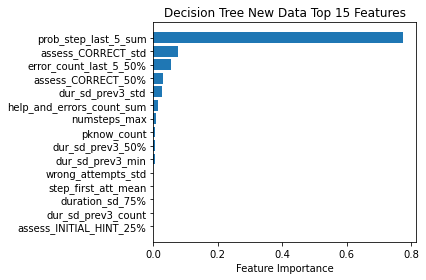

In [9]:
#New Feature Importance
#clf = xgb.XGBClassifier(random_state=42)
clf = DecisionTreeClassifier(max_depth = 5, random_state = 42)

sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_resample(df[features], df[label])

# Train the model
clf.fit(X_train, Y_train)
importances = clf.feature_importances_
num_features = 15
indices = np.argsort(importances)

cols = np.array(X_train.columns)
for i,col in enumerate(cols):
    if ('OK' in col):
        cols[i] = cols[i].replace('OK','CORRECT')
        
fig, ax = plt.subplots()
ax.set_title('Decision Tree New Data Top 15 Features')
ax.set_xlabel('Feature Importance')
ax.barh(range(num_features), importances[indices][-num_features:])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(cols[indices][-num_features:])
plt.tight_layout()
fig.savefig('dt_new_top_features.png')

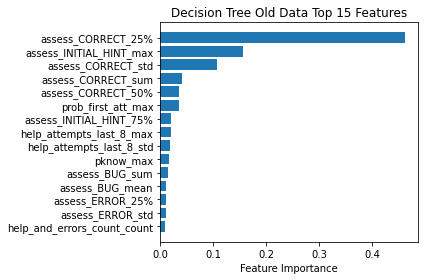

In [10]:
#Old Feature Importance
#clf = xgb.XGBClassifier(random_state=42)
clf = DecisionTreeClassifier(max_depth = 5, random_state = 42)

sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_resample(df2[features], df2[label])

# Train the model
clf.fit(X_train,Y_train)
importances = clf.feature_importances_
num_features = 15
indices = np.argsort(importances)
cols = np.array(X_train.columns)
for i,col in enumerate(cols):
    if ('OK' in col):
        cols[i] = cols[i].replace('OK','CORRECT')
        

fig, ax = plt.subplots()
ax.set_title("Decision Tree Old Data Top 15 Features")
ax.set_xlabel('Feature Importance')
ax.barh(range(num_features), importances[indices][-num_features:])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(cols[indices][-num_features:])
plt.tight_layout()
fig.savefig('dt_old_top_features.png')

In [21]:
;'
]['roc_auc_old = 0.921
roc_auc_new = 0.398
old_se = standard_error(roc_auc_old, y.value_counts()[1],y.value_counts()[0])
new_se =  standard_error(roc_auc_new, y.value_counts()[1],y.value_counts()[0])
z_scor = z_score(roc_auc_new, roc_auc_old, new_se, old_se)
print("Z-Score O versus N: ", z_scor, "\n")
print("P-value: ", scipy.stats.norm.sf(abs(z_scor))*2)

Z-Score O versus N:  -7.9255691241115 

P-value:  2.2710377535469903e-15
